In [147]:
#---- Import Statements ----#
#These imports are the basic imports used almost everywhere, no explaination needed
import numpy as np
import matplotlib.pyplot as plt
import glob
import math

#These are used at various points throughout the program, or are just artifacts from
#previous iterations of the program.
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
from scipy.optimize import curve_fit
from scipy import signal                    #Import statements
from scipy.fftpack import fft, fftshift
from numpy import exp, linspace, random

from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns

from astropy.wcs import WCS
from reproject import reproject_interp #import reproject
from ccdproc import wcs_project,fits_ccddata_reader,Combiner, combine
from astropy.nddata import CCDData
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clipped_stats
import photutils
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus 
from astropy.stats import mad_std
from scipy.optimize import curve_fit
import gc
from IPython import display
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from photutils import aperture_photometry, CircularAperture
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier as v
from astropy.utils.console import ProgressBar
import astropy.units as u
import os 
import time
from sys import exit
from astroquery.sdss import SDSS
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import r2_score, mean_squared_error
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [148]:
def pre_processing(mixed_data):
    scaler = preprocessing.MinMaxScaler()
    mixed_data = np.array(mixed_data)
    centered_data = mixed_data  - mixed_data.mean(axis=1, keepdims=True)
    centered_data =scaler.fit_transform(centered_data)

    covarinace_matrix = np.cov(centered_data)
    eigenvalues,eigenvectors = np.linalg.eigh(covarinace_matrix)
    diagonal_matrix = np.diag(eigenvalues)
    diagonal_matrix_inverse = np.sqrt(np.linalg.inv(diagonal_matrix))
    whitened_mixed_data = np.dot(eigenvectors, np.dot(diagonal_matrix_inverse, np.dot(eigenvectors.T, mixed_data)))
    
    return whitened_mixed_data

def star_function(x_range,a,b,c,e,f):
    curve = []
    for x in range(int(x_range)):
        val = -a * np.sin(b * x) 
        curve.append(val)
    return curve 

def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())

    return w_new

def mix_sources(sources,xcoords):
    
    
    min_length = 10**10
    for i in range(len(sources)):
        length = len(sources[i])
        if length < min_length:
            min_length = length
    for i in range(len(sources)):
        sources[i] = sources[i][0:min_length]
        xcoords[i] = xcoords[i][0:min_length]   
#     #generate mixing matrix
    A = []
    for i in range(len(sources)):
        row = []
        for j in range(len(sources)):
            weighting_coeff = random.uniform(0, 11)
            row.append(weighting_coeff)
        A.append(row)
        
    mixed_signals = []
    
    for i in range(len(A)):
        mixture = []
        for j in range(len(A[i])):
            mixture.append(sources[j] * A[i][j])
        mixture = np.sum(mixture,axis=0)
        mixed_signals.append(mixture)
    return mixed_signals,xcoords,length

In [149]:
def g(x):
    return np.tanh(x)
def g_der(x):
    return 1 - g(x) * g(x)

def ica(mixed_sources, iterations, tolerance=1e-5):
    mixed_sources = pre_processing(mixed_sources)
    num_components = mixed_sources.shape[0]
    unmixing_matrix = np.zeros((num_components, num_components), dtype=mixed_sources.dtype)

    for i in range(num_components):
        base_case = np.random.rand(num_components)
        for j in range(iterations):
            new_base_case = calculate_new_w(base_case, mixed_sources)
            if i >= 1:
                new_base_case = new_base_case - np.dot(np.dot(new_base_case, unmixing_matrix[:i].T), unmixing_matrix[:i])
            distance = np.abs(np.abs((base_case * new_base_case).sum()) - 1)
            base_case = new_base_case
            if distance < tolerance:
                break
        unmixing_matrix[i, :] = base_case
        
    unmixed_sources = np.dot(unmixing_matrix, mixed_sources)
    return unmixed_sources   

<ipython-input-150-5646da265958>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-150-5646da265958>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-150-5646da265958>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retur

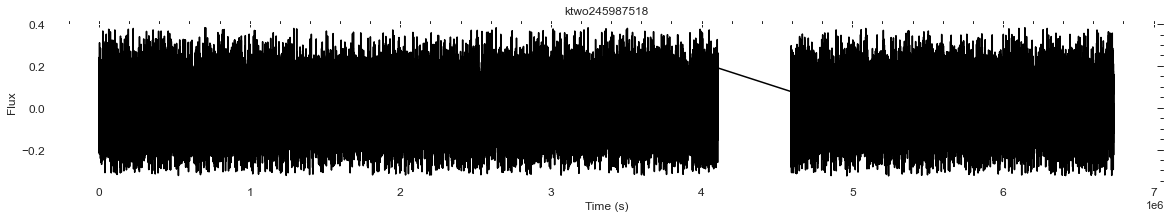

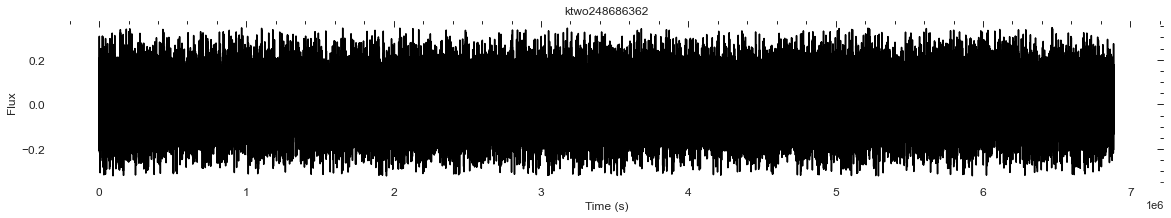

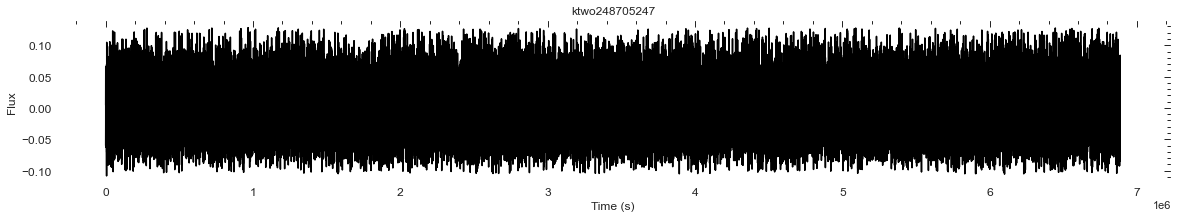

In [150]:
lightcurves = []
xcoords = []
count = 0
for i in glob.glob("*.txt"):
    flistX = np.loadtxt(i,usecols=(0))
    flistY = np.loadtxt(i,usecols=(1))
    lightcurves.append(flistY)
    xcoords.append(flistX)
    plt.figure(figsize=(20,3))
    plt.plot(flistX,flistY,c='black')
    plt.minorticks_on()
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tick_params(which='minor', direction='in', right='on', top='on', length=4, width = 1.0)
    plt.tick_params(which='major', direction='in', labelsize=12, right='on', top='on', length=7, width = 1.0)
    plt.ylabel('Flux') #This marks the Y axis of the graph
    plt.xlabel('Time (s)') #This marks the X axis of the graph
    plt.title(i.replace('.txt', ''))
#     plt.savefig("lc"+str(count)+'.jpg')
    count +=1

<ipython-input-151-091b7eaf4502>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-151-091b7eaf4502>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-151-091b7eaf4502>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

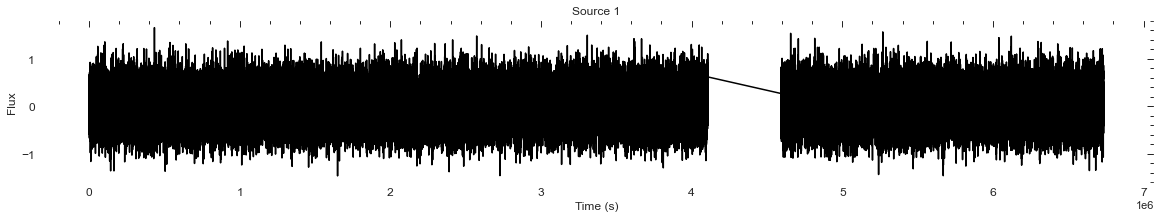

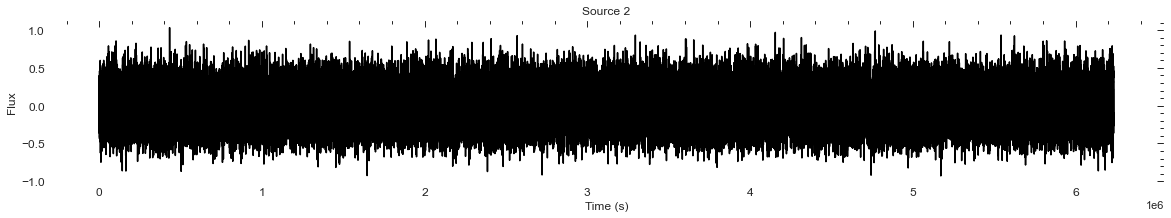

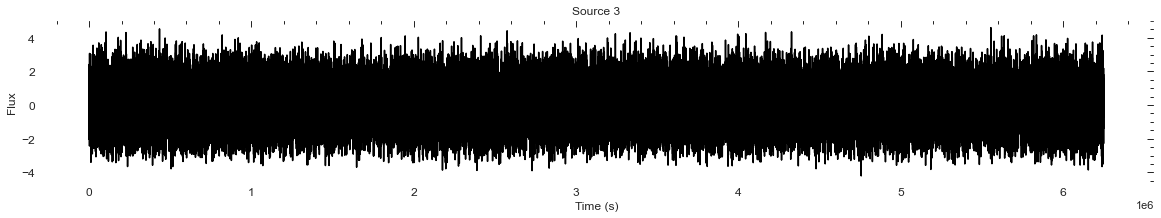

In [151]:
mixed_sources,xcoords,length = mix_sources(lightcurves,xcoords)
for i in range(len(mixed_sources)):
    plt.figure(figsize=(20,3))
    plt.plot(xcoords[i],mixed_sources[i],c='black')
    plt.minorticks_on()
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tick_params(which='minor', direction='in', right='on', top='on', length=4, width = 1.0)
    plt.tick_params(which='major', direction='in', labelsize=12, right='on', top='on', length=7, width = 1.0)
    plt.ylabel('Flux') #This marks the Y axis of the graph
    plt.xlabel('Time (s)') #This marks the X axis of the graph
    plt.title("Source "+str(i+1))
#     plt.savefig("mixed"+str(i+1)+'.jpg')

<ipython-input-152-580438b3e426>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-152-580438b3e426>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-152-580438b3e426>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned

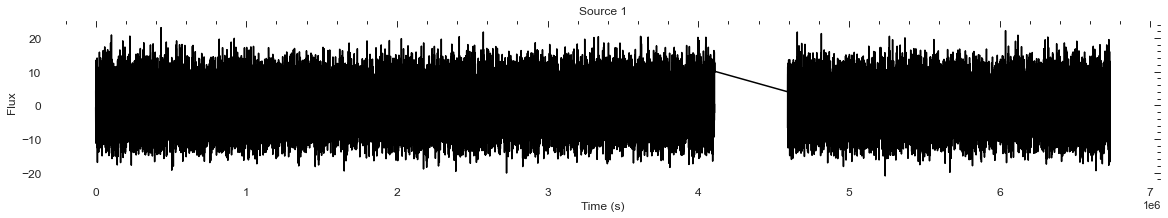

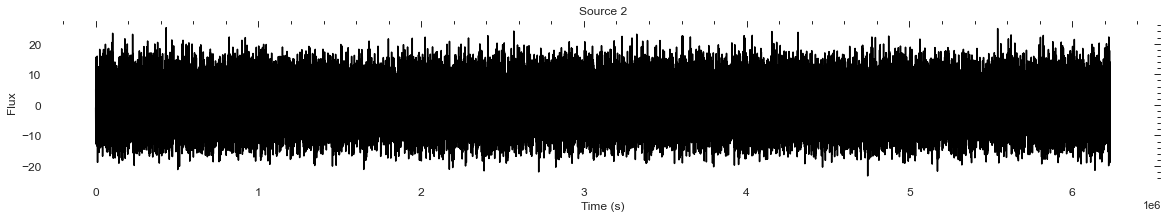

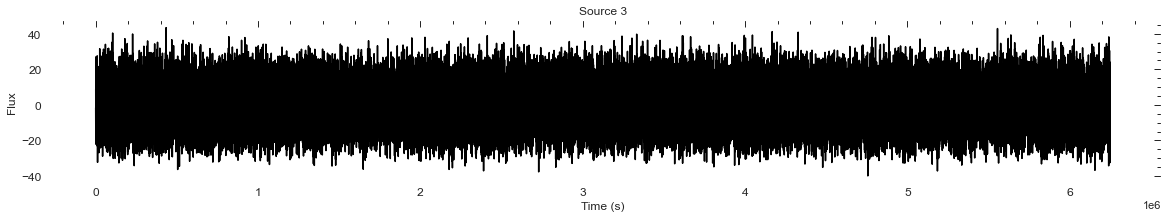

In [152]:
from sklearn import preprocessing
processed_mixed_sources = pre_processing(mixed_sources)
for i in range(len(processed_mixed_sources)):
    plt.figure(figsize=(20,3))
    plt.plot(xcoords[i],processed_mixed_sources[i],c='black')
    plt.minorticks_on()
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tick_params(which='minor', direction='in', right='on', top='on', length=4, width = 1.0)
    plt.tick_params(which='major', direction='in', labelsize=12, right='on', top='on', length=7, width = 1.0)
    plt.ylabel('Flux') #This marks the Y axis of the graph
    plt.xlabel('Time (s)') #This marks the X axis of the graph
    plt.title("Source "+str(i+1))
#     plt.savefig("processed_lc"+str(i+1)+'.jpg')

In [153]:
S = ica(processed_mixed_sources, iterations=500)

In [154]:
from operator import truediv

In [155]:
lamda_list = []
for i in range(len(S)):
    res = list(map(truediv, lightcurves[i], S[i]))
    lamda = np.mean(res)
    print(lamda)
    S[i] = lamda*np.array(S[i])
    lamda_list.append(lamda_list)

0.0006206535432581302
-0.7110997433306351
-0.11833672347958332


<ipython-input-156-eb9abfbc07ab>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-156-eb9abfbc07ab>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


The error in this ICA decomposition is: 4.355538034056605%
The error in this ICA decomposition is: 15.64980606755076%


<ipython-input-156-eb9abfbc07ab>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


The error in this ICA decomposition is: 4.756649243698847%


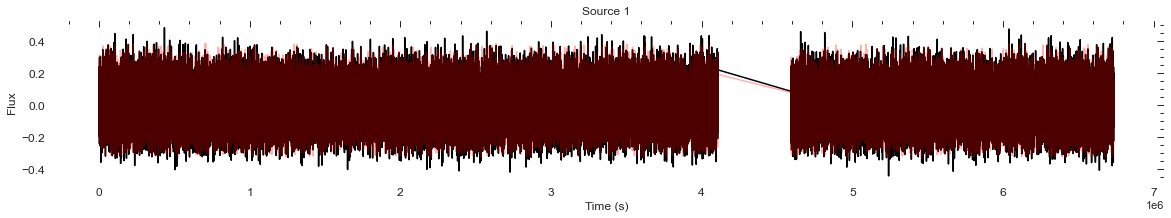

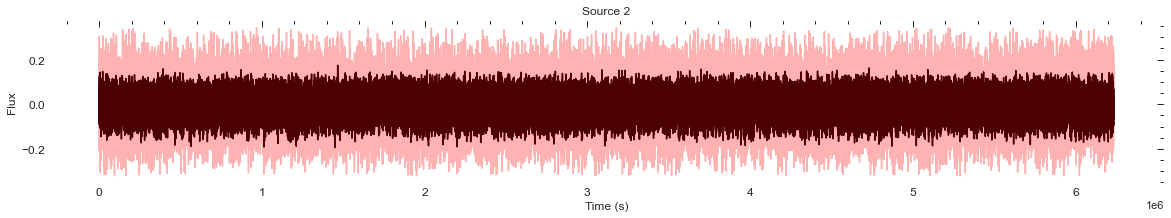

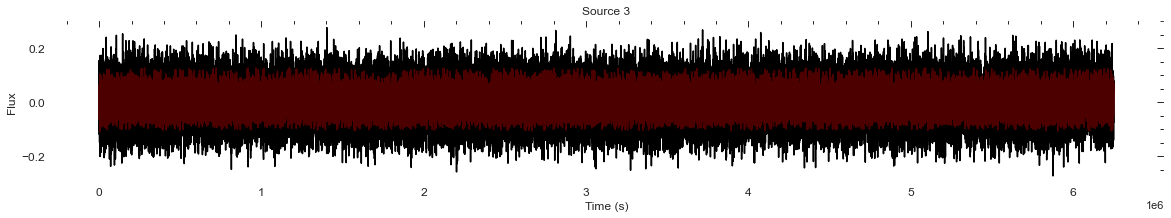

In [156]:
for i in range(len(S)):
    plt.figure(figsize=(20,3))
    plt.plot(xcoords[i],S[i],c='black')
    plt.plot(xcoords[i],lightcurves[i],c='red', alpha=0.3)
    plt.minorticks_on()
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tick_params(which='minor', direction='in', right='on', top='on', length=4, width = 1.0)
    plt.tick_params(which='major', direction='in', labelsize=12, right='on', top='on', length=7, width = 1.0)
    plt.ylabel('Flux') #This marks the Y axis of the graph
    plt.xlabel('Time (s)') #This marks the X axis of the graph
    plt.title("Source "+str(i+1))
#     plt.savefig('layered_lightcurve'+str(i+1)+'.jpg')
#     plt.xlim(0,10000)
    
    err_list = []
    for j in range(len(S[i])):
        err = np.abs(S[i][j]-lightcurves[i][j]/S[i][j])
        err_list.append(err)
    err_total = np.mean(err_list)
    print("The error in this ICA decomposition is: "+str(err_total)+"%")

<ipython-input-170-22b829be3698>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


The error in this ICA decomposition is: 4.355538034056605%


<ipython-input-170-22b829be3698>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


The error in this ICA decomposition is: 15.64980606755076%


<ipython-input-170-22b829be3698>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


The error in this ICA decomposition is: 4.756649243698847%


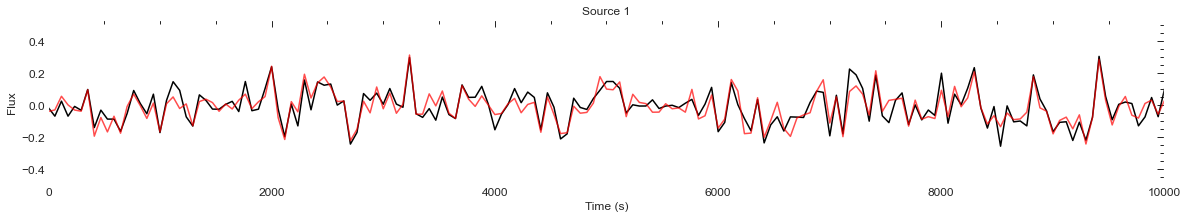

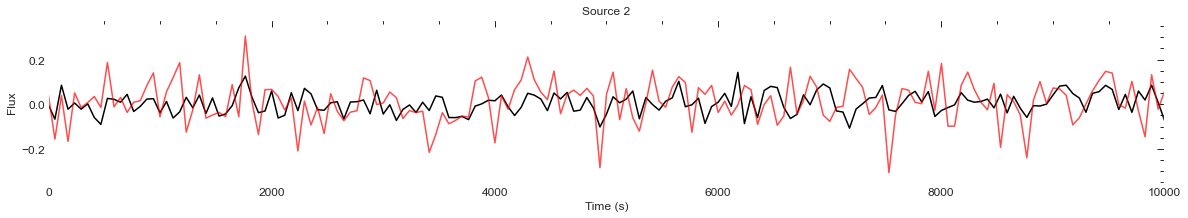

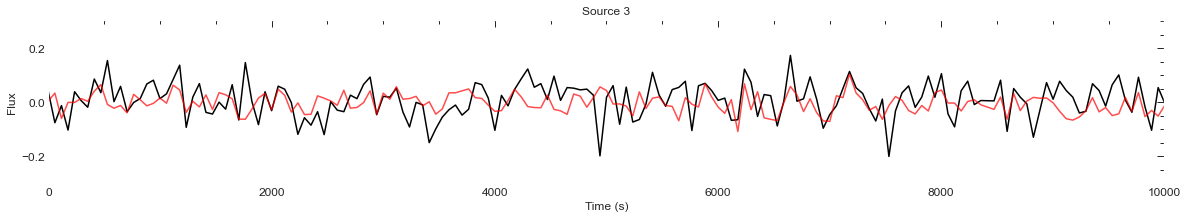

In [170]:
for i in range(len(S)):
    plt.figure(figsize=(20,3))
    plt.plot(xcoords[i],S[i],c='black')
    plt.plot(xcoords[i],lightcurves[i],c='red', alpha=0.7)
    plt.minorticks_on()
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tick_params(which='minor', direction='in', right='on', top='on', length=4, width = 1.0)
    plt.tick_params(which='major', direction='in', labelsize=12, right='on', top='on', length=7, width = 1.0)
    plt.ylabel('Flux') #This marks the Y axis of the graph
    plt.xlabel('Time (s)') #This marks the X axis of the graph
    plt.title("Source "+str(i+1))
    plt.xlim(0,10000)
    plt.savefig("snapshot_1"+str(i+1)+'.jpg')
    
    err_list = []
    for j in range(len(S[i])):
        err = np.abs(S[i][j]-lightcurves[i][j]/S[i][j])
        err_list.append(err)
    err_total = np.mean(err_list)
    print("The error in this ICA decomposition is: "+str(err_total)+"%")

<ipython-input-158-fde638811922>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-158-fde638811922>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-158-fde638811922>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retur

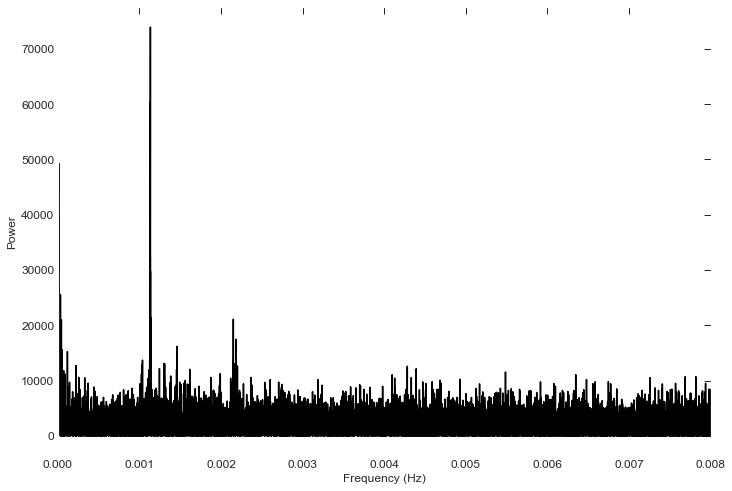

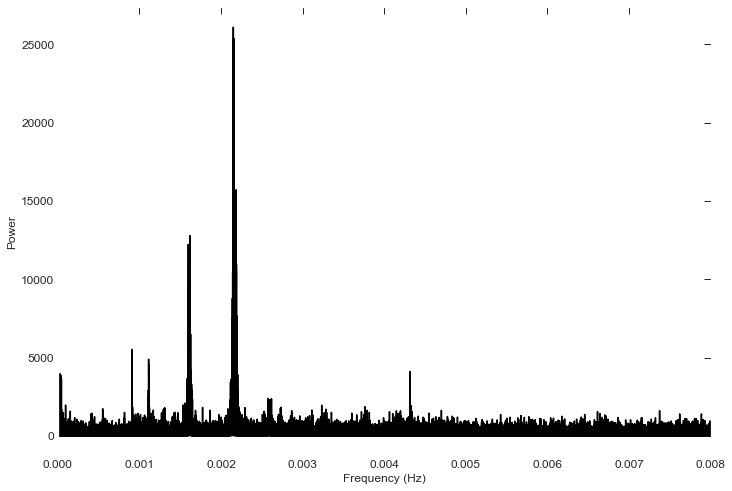

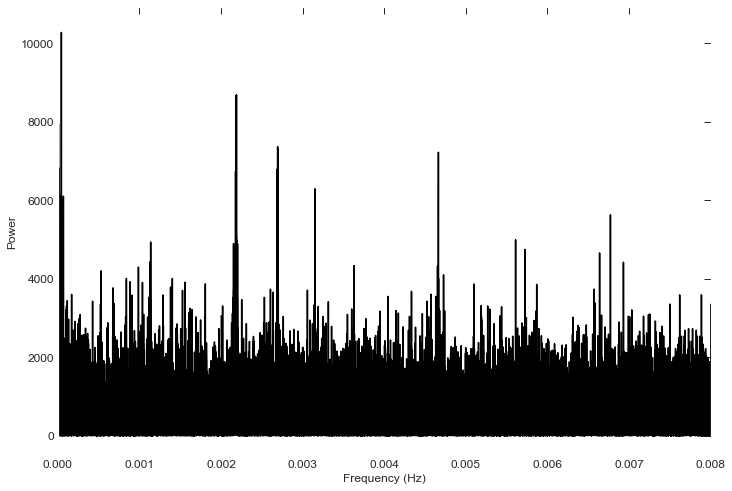

In [158]:
from scipy.fft import fft, fftfreq

SAMPLE_RATE = 1/58
DURATION = xcoords[0][-1]

N = SAMPLE_RATE * DURATION

for i in range(len(S)):
    yf = np.abs(fft(S[i]))**2
    xf = fftfreq(int(N), 1 / SAMPLE_RATE)[0:len(yf)]
    plt.figure()
    plt.plot(xf, yf,c='black')
    plt.xlim(0,0.008)
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tick_params(which='minor', direction='in', right='on', top='on', length=4, width = 1.0)
    plt.tick_params(which='major', direction='in', labelsize=12, right='on', top='on', length=7, width = 1.0)
    plt.ylabel('Power') #This marks the Y axis of the graph
    plt.xlabel('Frequency (Hz)') #This marks the X axis of the graph
#     plt.savefig("Uncombined_Source"+str(i+1)+'.jpg')

<ipython-input-159-7e01213dad9f>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-159-7e01213dad9f>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-159-7e01213dad9f>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retur

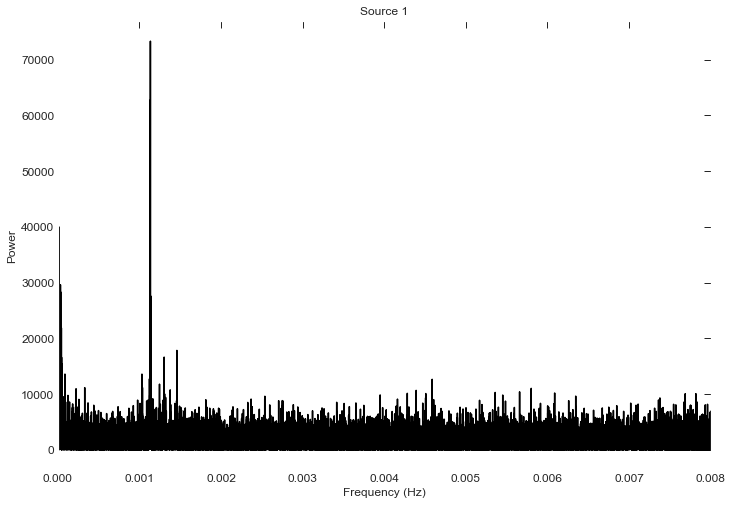

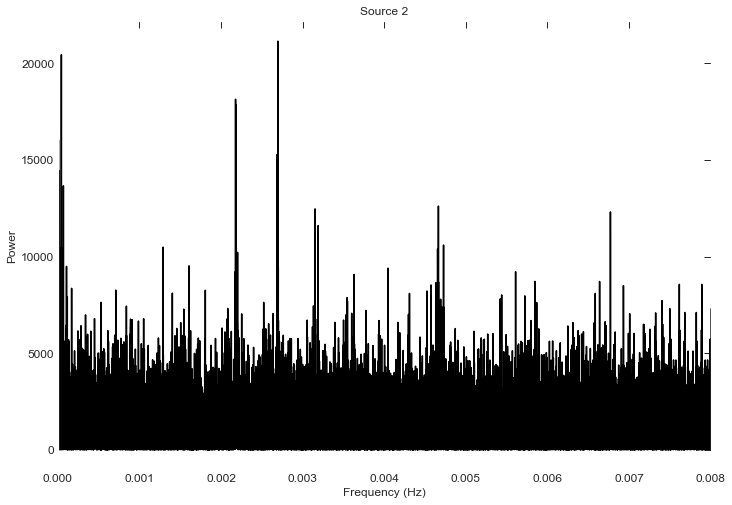

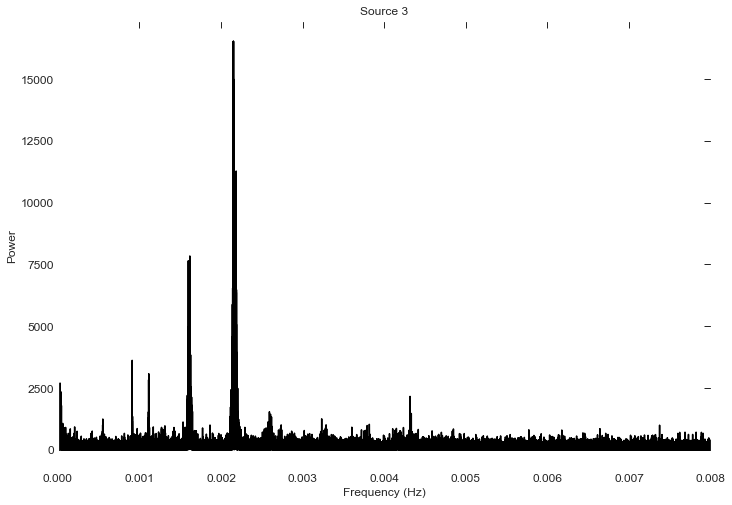

In [159]:
SAMPLE_RATE = 1/58
DURATION = xcoords[0][-1]

N = SAMPLE_RATE * DURATION

for i in range(len(lightcurves)):
    yf = np.abs(fft(lightcurves[i]))**2
    xf = fftfreq(int(N), 1 / SAMPLE_RATE)[0:len(yf)]
    plt.figure()
    plt.plot(xf, yf,c='black')
    plt.xlim(0,0.008)
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tick_params(which='minor', direction='in', right='on', top='on', length=4, width = 1.0)
    plt.tick_params(which='major', direction='in', labelsize=12, right='on', top='on', length=7, width = 1.0)
    plt.ylabel('Power') #This marks the Y axis of the graph
    plt.xlabel('Frequency (Hz)') #This marks the X axis of the graph
    plt.title("Source "+str(i+1))
#     plt.savefig("Original_Source"+str(i+1)+'.jpg')

<ipython-input-171-80f01837bab7>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-171-80f01837bab7>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<ipython-input-171-80f01837bab7>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retur

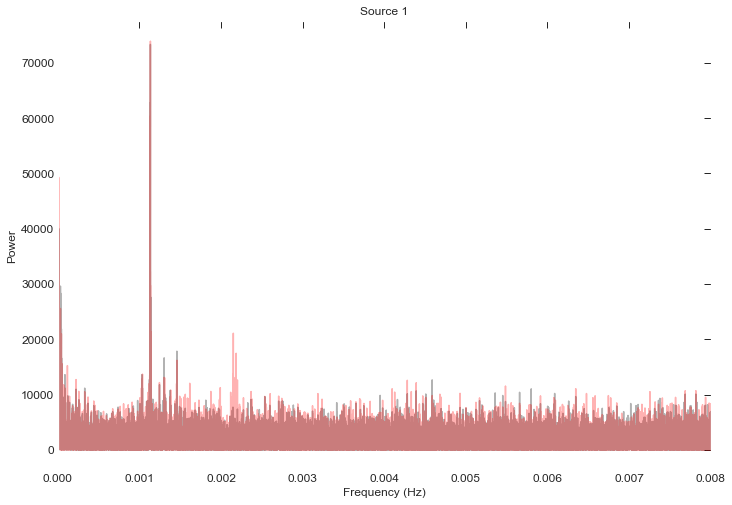

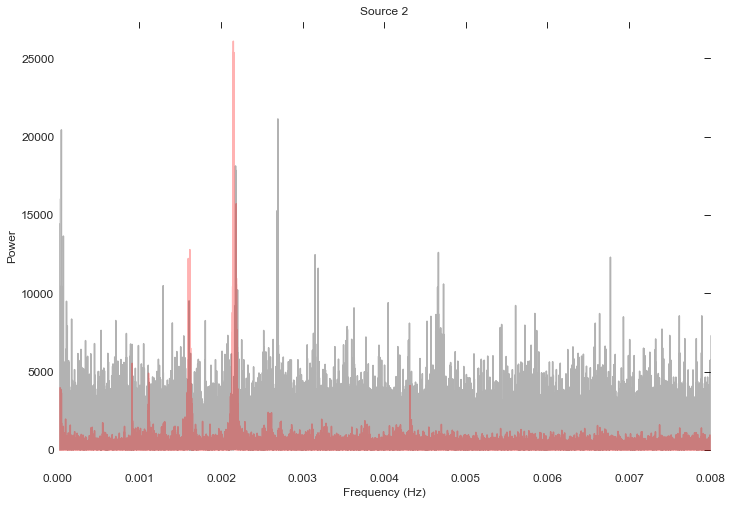

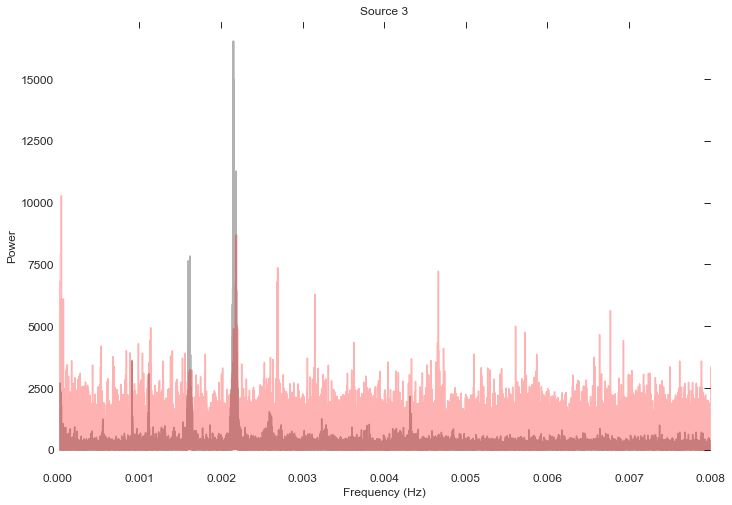

In [171]:
SAMPLE_RATE = 1/58
DURATION = xcoords[0][-1]

N = SAMPLE_RATE * DURATION

for i in range(len(lightcurves)):
    yf = np.abs(fft(lightcurves[i]))**2
    xf = fftfreq(int(N), 1 / SAMPLE_RATE)[0:len(yf)]
    yf1 = np.abs(fft(S[i]))**2
    xf1 = fftfreq(int(N), 1 / SAMPLE_RATE)[0:len(yf1)]
    plt.figure()
    plt.plot(xf, yf,c='black',alpha=0.3)
    plt.plot(xf1, yf1,alpha =0.3,c='red')
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.xlim(0,0.008)
    ax.set_facecolor("white")
    plt.tick_params(which='minor', direction='in', right='on', top='on', length=4, width = 1.0)
    plt.tick_params(which='major', direction='in', labelsize=12, right='on', top='on', length=7, width = 1.0)
    plt.ylabel('Power') #This marks the Y axis of the graph
    plt.xlabel('Frequency (Hz)') #This marks the X axis of the graph
    plt.title("Source "+str(i+1))
    plt.savefig("Source_final"+str(i+1)+'.jpg')

In [161]:
#This is the code to plot the distribution of errors. Only run this once becuase it's going to take a WHILE sorry :(
#if you run this by accident, pray.

# ranges = [1,2,5,10,20]
# totals = []
# for l in ranges:
#     err_totals = []
#     for i in range(20):
#         mixed_sources,xcoords,length = mix_sources(lightcurves,xcoords)
#         processed_mixed_sources = pre_processing(mixed_sources)
#         S = ica(processed_mixed_sources, iterations=500)
#         lamda_list = []
#         for j in range(len(S)):
#             res = list(map(truediv, lightcurves[j], S[j]))
#             lamda = np.mean(res)
#             S[j] = lamda*np.array(S[j])
#             lamda_list.append(lamda_list)
#             err_list = []
#             for k in range(len(S[j])):
#                 err = np.abs(S[j][k]-lightcurves[j][k]/S[j][k])
#                 err_list.append(err)
#             err_total = np.mean(err_list)
#             if err_total < 100:
#                 err_totals.append(err_total)
#     totals.append(err_totals)

The probability of getting an error higher than 10% is: 16.014234875444842


<ipython-input-168-1c3d8d0e18dc>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


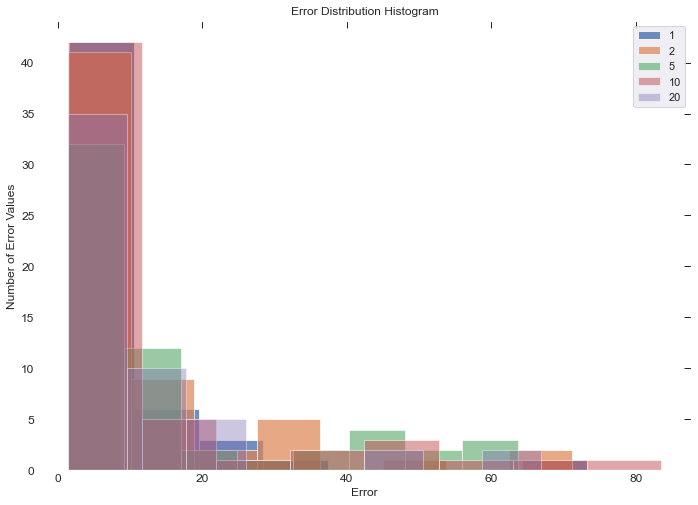

In [168]:
good_vals = []
bad_vals = []
for i in range(len(totals)):
    plt.hist(totals[i],bins=8,label=ranges[i],alpha=0.8-0.1*i)
    plt.legend()
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tick_params(which='minor', direction='in', right='on', top='on', length=4, width = 1.0)
    plt.tick_params(which='major', direction='in', labelsize=12, right='on', top='on', length=7, width = 1.0)
    plt.ylabel('Number of Error Values') #This marks the Y axis of the graph
    plt.xlabel('Error') #This marks the X axis of the graph
    plt.title("Error Distribution Histogram")
#     plt.savefig("hist.jpg")
    for j in totals[i]:
        if j < 20:
            good_vals.append(j)
        else:
            bad_vals.append(j)
p_good = 100 * (1-len(good_vals)/(len(good_vals)+len(bad_vals)))
print('The probability of getting an error higher than 10% is: '+str(p_good))